In [48]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score

from ipywidgets import interact, interactive, interact_manual, FloatSlider, IntSlider, Layout
from IPython.display import Image


In [49]:
def load_data(filepath):
    
    df = pd.read_csv(filepath, index_col=0)
    df['road_type_dummy'] = pd.get_dummies(df['road_type'], drop_first=True)
    df['night_dummy'] = pd.get_dummies(df['day_night'], drop_first=True)

    X = df[['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
       'drifting_score', 'speeding_score', 'follow_score', 'speed_mph', 'road_type_dummy', 'night_dummy']]
    y = df['class_normal_bool']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


In [50]:
def load_model(filepath):
    
    with open(filepath, "rb") as pfile:
        rf_final = pickle.load(pfile)
        
    return rf_final

In [51]:
X_train, X_test, y_train, y_test = load_data('UAH-DRIVESET-classification.csv')

In [52]:
rf_final = load_model('models/rf_final.pickle')

y_rf_final_pred = rf_final.predict(X_test)
y_rf_final_pred_prob = rf_final.predict_proba(X_test)[:, 1]

print('Test set scores:\n')
print(f'\tFbeta (beta=2):\t {fbeta_score(y_test, y_rf_final_pred, beta=2):.4f}')


Test set scores:

	Fbeta (beta=2):	 0.9925


In [53]:
road_dummies_dict = {'Highway':0, 'Secondary':1}
night_dummies_dict = {'Day':0, 'Night':1}

class_dict = {0: 'Normal', 1:'Abnormal'}


In [75]:
def new_prediction(acc, brake, turn, weave, drift, speeding, follow, speed, road_type='Highway', night='Day'):
    road_type_bool = road_dummies_dict[road_type]
    night_bool = night_dummies_dict[night]

    new_test = np.array([acc, brake, turn, weave, drift, speeding, follow, speed, road_type_bool, night_bool]).reshape(1, -1)
    y_pred = rf_final.predict(new_test)[0]
    y_pred_prob = rf_final.predict_proba(new_test)[:, 1][0]
    
    print(f'Predicted: {class_dict[y_pred]} driving')
    print(f'(Probability: {y_pred_prob:.2f})')
    display(Image(filename=f'figures/{class_dict[y_pred]}.png', width=225) )
    
    return


In [76]:
interactive(lambda Acceleration: new_prediction(Acceleration,100,100,100,100,100,100,45,'Highway','Day'), Acceleration=(0,100,1))


interactive(children=(IntSlider(value=50, description='Acceleration'), Output()), _dom_classes=('widget-intera…

In [79]:
im = interact_manual(new_prediction, acc=IntSlider(100,0,100,1), brake=IntSlider(100,0,100,1), turn=IntSlider(100,0,100,1),
         weave=IntSlider(100,0,100,1), drift=IntSlider(100,0,100,1), speeding=IntSlider(100,0,100,1),
         follow=IntSlider(100,0,100,1), speed=IntSlider(40,30,80,1),
         road_type=['Highway','Secondary'], night=['Day','Night']);

labels = ['Acceleration', 'Braking', 'Turning', 'Weaving', 'Drifting', 'Speeding', 'Following']
for i,lab in enumerate(labels):
    im.widget.children[i].description = f'{lab}'

im.widget.children[i+1].description = 'Speed (mph)'
im.widget.children[i+2].description = 'Road type'
im.widget.children[i+3].description = 'Lighting'


interactive(children=(IntSlider(value=100, description='acc'), IntSlider(value=100, description='brake'), IntS…

In [81]:
for _ in range(5):
    i = X_test.sample(n=1).index
    display(X_test.loc[i], y_test.loc[i])

,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,speed_mph,road_type_dummy,night_dummy
29500,100.0,99.9,100.0,100.0,78.9,100.0,95.5,59.784986,0,0


29500    0
Name: class_normal_bool, dtype: int64

,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,speed_mph,road_type_dummy,night_dummy
13326,98.8,0.0,100.0,100.0,82.8,69.8,74.3,46.711181,0,0


13326    1
Name: class_normal_bool, dtype: int64

,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,speed_mph,road_type_dummy,night_dummy
6815,74.9,66.9,0.0,100.0,92.4,65.4,70.1,69.326431,0,0


6815    1
Name: class_normal_bool, dtype: int64

,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,speed_mph,road_type_dummy,night_dummy
28543,100.0,100.0,100.0,100.0,65.4,100.0,100.0,52.687595,1,0


28543    0
Name: class_normal_bool, dtype: int64

,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,speed_mph,road_type_dummy,night_dummy
25956,66.3,49.5,100.0,100.0,57.1,0.0,7.6,63.256184,1,0


25956    1
Name: class_normal_bool, dtype: int64

In [106]:
mask = (X_train['acceleration_score'] > 95) & (X_train['braking_score'] > 95) & (X_train['turning_score'] > 95) \
        & (X_train['weaving_score'] > 95) & (X_train['speeding_score'] > 90) & (X_train['follow_score'] > 90) \
        & (X_train['drifting_score'] < 72) & (X_train['speed_mph'] < 60) & (X_train['road_type_dummy'] == 1) \
        & (X_train['night_dummy'] == 0)
X_train[mask]

,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,speed_mph,road_type_dummy,night_dummy
9570,100.0,100.0,100.0,100.0,62.3,96.5,97.3,45.583902,1,0
9942,99.9,100.0,100.0,100.0,68.8,96.1,98.3,42.804513,1,0
20467,100.0,98.5,100.0,100.0,62.7,93.8,98.8,53.285710,1,0
9397,100.0,100.0,100.0,100.0,63.9,98.5,100.0,49.086921,1,0
9414,100.0,100.0,100.0,100.0,63.9,97.5,100.0,56.487123,1,0
...,...,...,...,...,...,...,...,...,...,...
9474,100.0,100.0,100.0,100.0,62.4,94.9,100.0,56.134572,1,0
9789,100.0,100.0,100.0,100.0,66.5,95.2,98.0,52.857299,1,0
9914,99.9,100.0,100.0,100.0,68.4,95.9,98.3,53.069622,1,0
9762,100.0,100.0,100.0,100.0,66.3,95.2,98.0,56.900304,1,0


(array([851.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

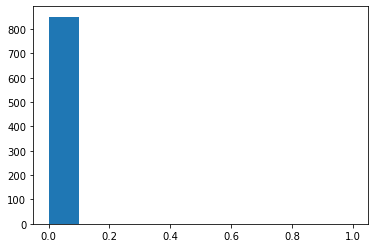

In [108]:
n = plt.hist(y_train[mask])
n

In [116]:
y_train[mask][500:550]

9769     0
20697    0
20641    0
20604    0
9481     0
9763     0
9735     0
9721     0
9552     0
20672    0
9777     0
20511    0
20522    0
20755    0
9638     0
9670     0
9843     0
9727     0
28555    0
9850     0
9716     0
20661    0
9894     0
9604     0
20719    0
9491     0
20594    0
9505     0
9455     0
9810     0
9957     0
9677     0
9930     0
9631     0
9475     0
9354     0
9628     0
9719     0
9828     0
9487     0
9980     1
9746     0
20625    0
9420     0
9506     0
9896     0
9848     0
20710    0
9718     0
20608    0
Name: class_normal_bool, dtype: int64

In [115]:
for i,n in enumerate(y_train[mask]):
    if n == 1:
        print(i)

540


In [117]:
X_train.iloc[9980]

acceleration_score     99.90000
braking_score         100.00000
turning_score         100.00000
weaving_score         100.00000
drifting_score         87.30000
speeding_score         99.80000
follow_score           99.40000
speed_mph              72.17939
road_type_dummy         0.00000
night_dummy             0.00000
Name: 17218, dtype: float64

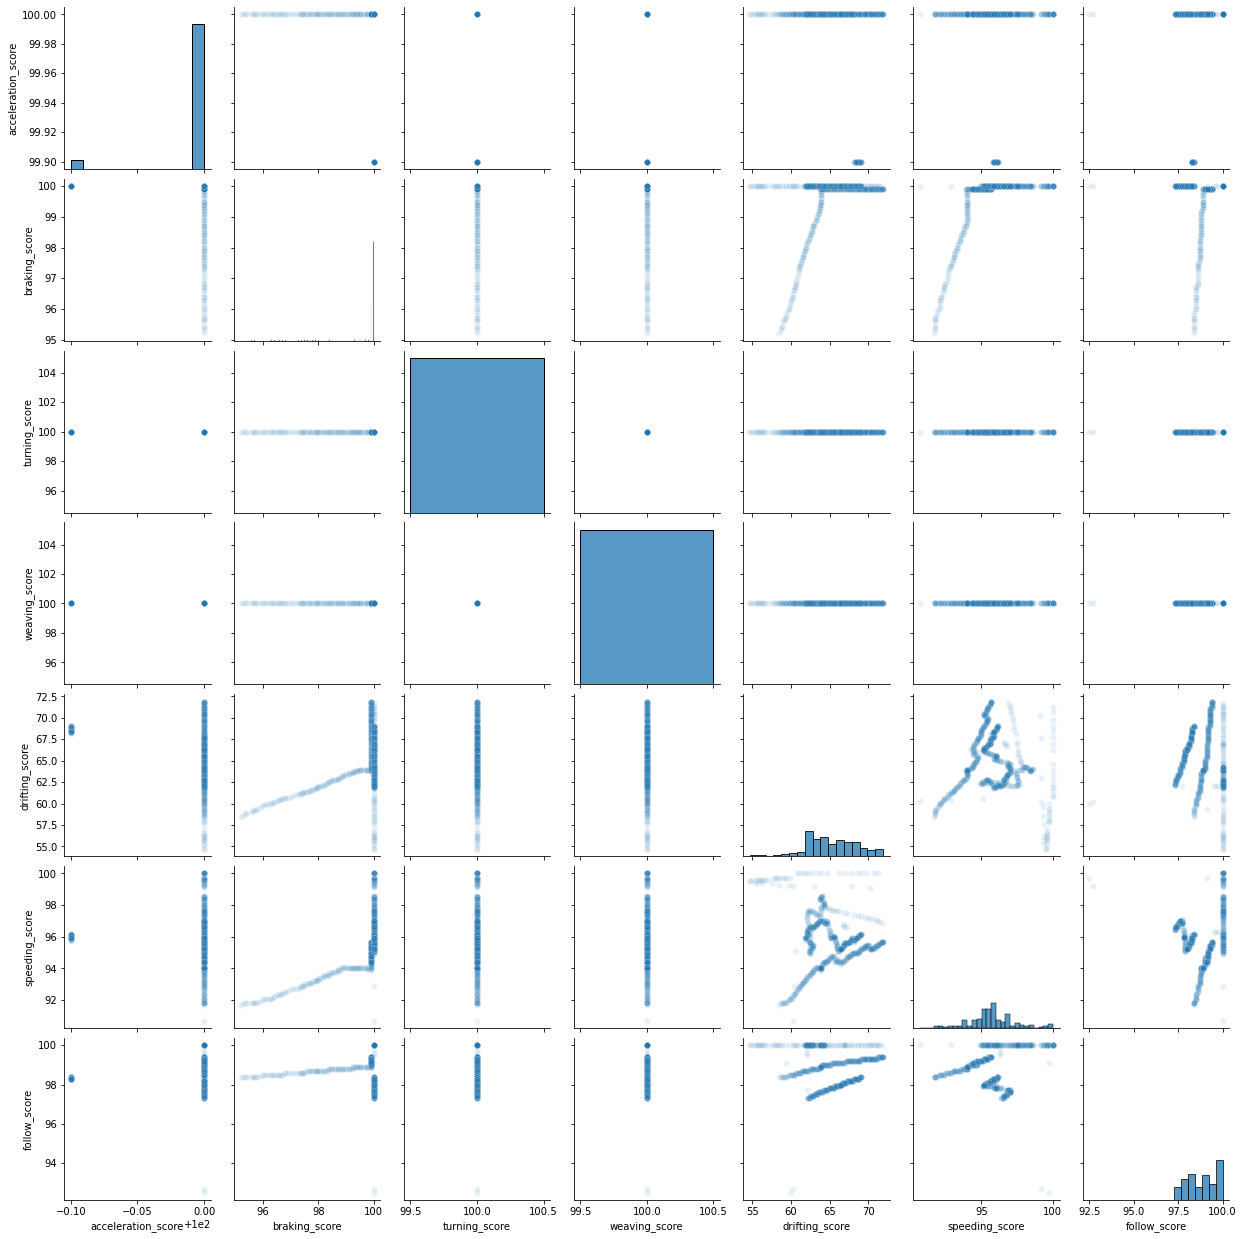

In [120]:
cols = ['acceleration_score',
        'braking_score', 'turning_score', 'weaving_score', 'drifting_score',
        'speeding_score', 'follow_score']

sns.pairplot(X_train[mask][cols], plot_kws={'alpha': 0.1})
